In [1]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset
import xgboost as xgb
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import roc_auc_score, log_loss
from sklearn.preprocessing import StandardScaler
import shap
import random
import matplotlib.pyplot as plt

from src.data_utils import split_data, create_sequences, prepare_distillation_data, aggregate_daily
from src.models import MarketRegimeGRU, MarketRegimeCNN
from src.train import DEVICE, train_student
import src.evaluation as evaluation

In [2]:
df = pd.read_parquet('data/final_df.parquet')
df.head()

,Date,Ticker,Ret_1d,Ret_21d,RSI_14d,Sector_Dispersion,Trend_Dist,Rel_Volume,Bull_Bear_Regime,Target_Regime_5d
0,2000-01-03,GE,-0.031176,0.110279,52.427610,0.039385,0.264959,1.200274,Bear,1.0
1,2000-01-03,CAT,0.032661,0.023408,58.447551,0.039385,-0.128287,1.432774,Bear,1.0
2,2000-01-03,RTX,-0.039221,0.061343,59.314112,0.039385,-0.014154,0.857426,Bear,1.0
3,2000-01-03,BRK-B,-0.036165,-0.047035,47.023795,0.016239,-0.168843,0.820248,Bear,1.0
4,2000-01-03,JPM,-0.063949,-0.081493,35.612084,0.016239,-0.080177,2.540854,Bear,1.0


In [3]:
def set_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seeds(42)

In [4]:
feature_map = {
    'Ret_1d': 'Ret_1d',
    'Ret_21d': 'Ret_21d',
    'RSI_14d': 'RSI_14d',
    'Ret1d_Std_Dev': 'Sector_Dispersion',
    'Price_vs_MA200': 'Trend_Dist',
    'Rel_Volume': 'Rel_Volume',
}
feature_cols = list(feature_map.values())

SEQ_LENGTH = 21
INPUT_DIM = len(feature_cols)

(X_dev, y_dev), (X_test, y_test) = split_data(df, feature_cols)

In [5]:
scaler = StandardScaler()
X_dev_scaled = X_dev.copy()
X_dev_scaled[feature_cols] = scaler.fit_transform(X_dev[feature_cols])

X_test_scaled = X_test.copy()
X_test_scaled[feature_cols] = scaler.transform(X_test[feature_cols])

data = {
    'train': prepare_distillation_data(X_dev_scaled, y_dev, feature_cols, SEQ_LENGTH),
    'test': prepare_distillation_data(X_test_scaled, y_test, feature_cols, SEQ_LENGTH)
}

test_indices = data['test']['indices']

print(f"Train shapes: sequence - {data['train']['seq'].shape}, tabular: {data['train']['beh'].shape}")
print(f"Test shapes: sequence - {data['test']['seq'].shape}, tabular: {data['test']['beh'].shape}")

Train shapes: sequence - (235688, 21, 6), tabular: (235688, 42)
Test shapes: sequence - (79715, 21, 6), tabular: (79715, 42)


In [6]:
# hyperparameters from baseline tuning
STUDENT_CONFIGS = {
    'XGBoost': {
        'model_class': xgb.XGBRegressor, 
        'params': {
            'n_estimators': 300,
            'learning_rate': 0.1,
            'max_depth': 3,
            'objective': 'reg:logistic',
            'n_jobs': -1,
            'random_state': 42,
        }
    },
    'DecisionTree': {
        'model_class': DecisionTreeRegressor,
        'params': {
            'max_depth': 10,
            'min_samples_leaf': 100,
            'random_state': 42
        }
    }
}

In [7]:
gru_params = {'hidden_dim': 64, 'lr': 0.001, 'dropout': 0.2, 'alpha': 0.5, 'gamma': 2.5}
gru_model = MarketRegimeGRU(INPUT_DIM, gru_params['hidden_dim'], 2, gru_params['dropout']).to(DEVICE)
gru_model.load_state_dict(torch.load('weights/GRU_best_weights.pt'))

cnn_params = {'filters': 32, 'kernel': 4, 'lr': 0.01, 'dropout': 0.2, 'alpha': 0.75, 'gamma': 2.5}
cnn_model = MarketRegimeCNN(INPUT_DIM, SEQ_LENGTH, cnn_params['dropout'], 
                            filters=cnn_params['filters'], kernel=cnn_params['kernel']).to(DEVICE)
cnn_model.load_state_dict(torch.load('weights/CNN_best_weights.pt'))

gru_model.eval()
cnn_model.eval()

MarketRegimeCNN(
  (conv1): Conv1d(6, 32, kernel_size=(4,), stride=(1,), padding=(2,), dilation=(2,))
  (relu): ReLU()
  (global_pool): AdaptiveAvgPool1d(output_size=1)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)

In [8]:
train_seq_tensor = torch.FloatTensor(data['train']['seq'])
loader_train_inf = DataLoader(TensorDataset(train_seq_tensor), batch_size=2048, shuffle=False)

gru_soft_labels = []
with torch.no_grad():
    for X_b, in loader_train_inf:
        logits = gru_model(X_b.to(DEVICE)).squeeze()
        probs = torch.sigmoid(logits).cpu().numpy()
        gru_soft_labels.extend(probs)

gru_soft_labels = np.array(gru_soft_labels)

cnn_soft_labels = []
with torch.no_grad():
    for X_b, in loader_train_inf:
        logits = cnn_model(X_b.to(DEVICE)).squeeze()
        probs = torch.sigmoid(logits).cpu().numpy()
        cnn_soft_labels.extend(probs)

cnn_soft_labels = np.array(cnn_soft_labels)

In [9]:
results = {}

gru_xgb, gru_xgb_metrics = train_student("XGBoost", STUDENT_CONFIGS, gru_soft_labels, data, df, test_indices)
results['GRU->XGB'] = gru_xgb_metrics

gru_dt, gru_dt_metrics = train_student("DecisionTree", STUDENT_CONFIGS, gru_soft_labels, data, df, test_indices)
results['GRU->DT'] = gru_dt_metrics

cnn_xgb, cnn_xgb_metrics = train_student("XGBoost", STUDENT_CONFIGS, cnn_soft_labels, data, df, test_indices)
results['CNN->XGB'] = cnn_xgb_metrics

cnn_dt, cnn_dt_metrics = train_student("DecisionTree", STUDENT_CONFIGS, cnn_soft_labels, data, df, test_indices)
results['CNN->DT'] = cnn_dt_metrics

Student (XGBoost) Performance:
Train AUC: 0.9551
Test AUC: 0.9432
Log Loss: 0.4199
Student (DecisionTree) Performance:
Train AUC: 0.9459
Test AUC: 0.9366
Log Loss: 0.4335
Student (XGBoost) Performance:
Train AUC: 0.9387
Test AUC: 0.9315
Log Loss: 0.4965
Student (DecisionTree) Performance:
Train AUC: 0.9277
Test AUC: 0.9162
Log Loss: 0.5074


In [10]:
test_seq_tensor = torch.FloatTensor(data['test']['seq'])
loader_test_inf = DataLoader(TensorDataset(test_seq_tensor), batch_size=2048, shuffle=False)

def get_teacher_probs(model, loader):
    model.eval()
    all_probs = []
    with torch.no_grad():
        for X_b, in loader:
            logits = model(X_b.to(DEVICE)).squeeze()
            probs = torch.sigmoid(logits).cpu().numpy()
            all_probs.extend(probs)
    return np.array(all_probs)

gru_test_probs = get_teacher_probs(gru_model, loader_test_inf)
cnn_test_probs = get_teacher_probs(cnn_model, loader_test_inf)

GRU->XGB Evaluation
Overall AUC: 0.9432
Onset Accuracy: 33.33%

Classification Report:
              precision    recall  f1-score   support

         0.0       0.91      0.96      0.94      1162
         1.0       0.84      0.68      0.75       324

    accuracy                           0.90      1486
   macro avg       0.88      0.82      0.84      1486
weighted avg       0.90      0.90      0.90      1486


Regime Performance:
Bull Market Accuracy: 0.9089
Bull Market AUC: 0.6776
Bear Market Accuracy: 0.8538
Bear Market AUC: 0.7066
MSE: 0.00541
R2 score: 0.8547
Binary agreement: 92.26%


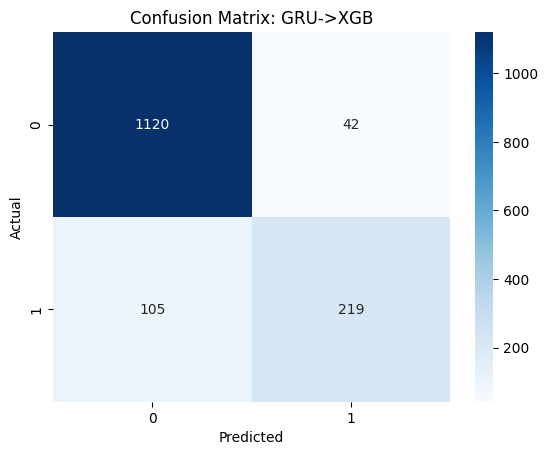

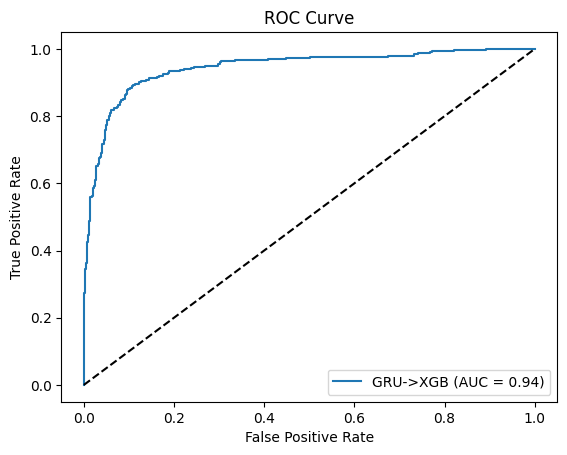

GRU->DT Evaluation
Overall AUC: 0.9366
Onset Accuracy: 41.67%

Classification Report:
              precision    recall  f1-score   support

         0.0       0.90      0.97      0.94      1162
         1.0       0.87      0.63      0.73       324

    accuracy                           0.90      1486
   macro avg       0.89      0.80      0.83      1486
weighted avg       0.90      0.90      0.89      1486


Regime Performance:
Bull Market Accuracy: 0.9050
Bull Market AUC: 0.6406
Bear Market Accuracy: 0.8632
Bear Market AUC: 0.7348
MSE: 0.00798
R2 score: 0.7857
Binary agreement: 92.06%


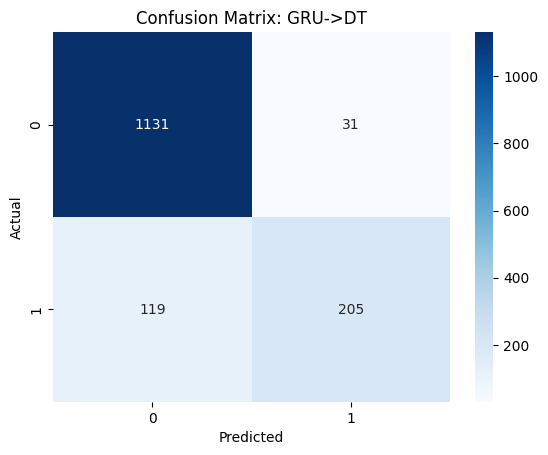

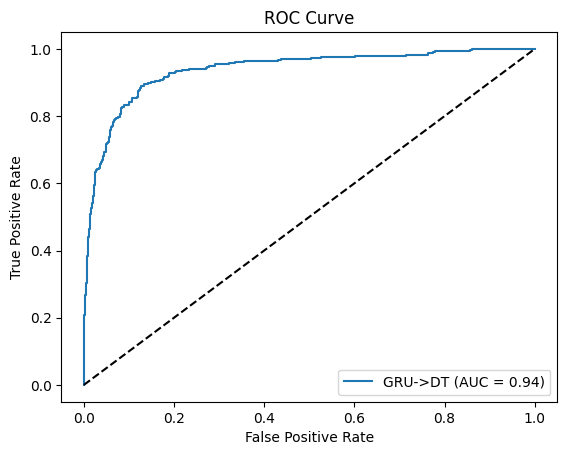

CNN->XGB Evaluation
Overall AUC: 0.9315
Onset Accuracy: 75.00%

Classification Report:
              precision    recall  f1-score   support

         0.0       0.94      0.93      0.93      1162
         1.0       0.74      0.77      0.76       324

    accuracy                           0.89      1486
   macro avg       0.84      0.85      0.84      1486
weighted avg       0.89      0.89      0.89      1486


Regime Performance:
Bull Market Accuracy: 0.8995
Bull Market AUC: 0.7472
Bear Market Accuracy: 0.8491
Bear Market AUC: 0.6740
MSE: 0.00134
R2 score: 0.9430
Binary agreement: 94.68%


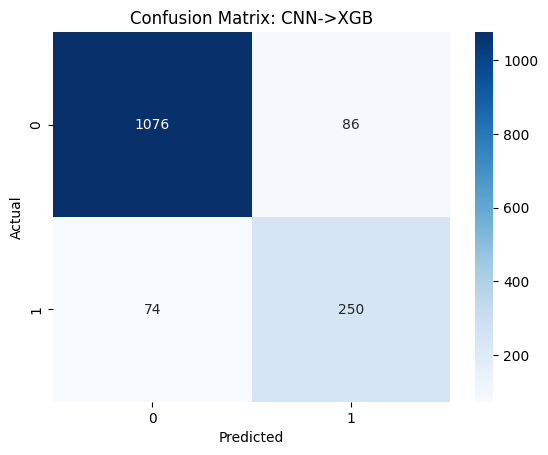

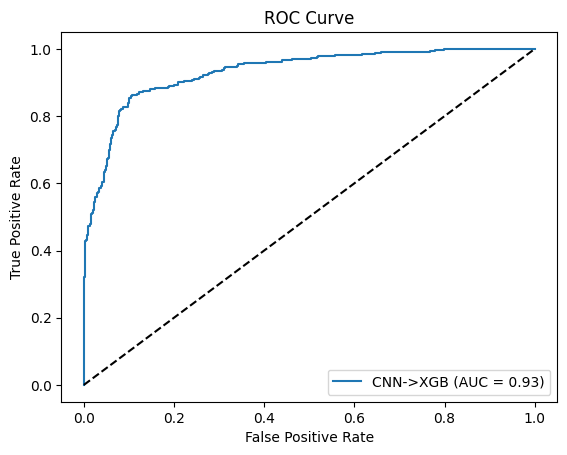

CNN->DT Evaluation
Overall AUC: 0.9162
Onset Accuracy: 66.67%

Classification Report:
              precision    recall  f1-score   support

         0.0       0.91      0.94      0.93      1162
         1.0       0.77      0.68      0.72       324

    accuracy                           0.89      1486
   macro avg       0.84      0.81      0.83      1486
weighted avg       0.88      0.89      0.88      1486


Regime Performance:
Bull Market Accuracy: 0.8948
Bull Market AUC: 0.6722
Bear Market Accuracy: 0.8302
Bear Market AUC: 0.6471
MSE: 0.00346
R2 score: 0.8529
Binary agreement: 91.45%


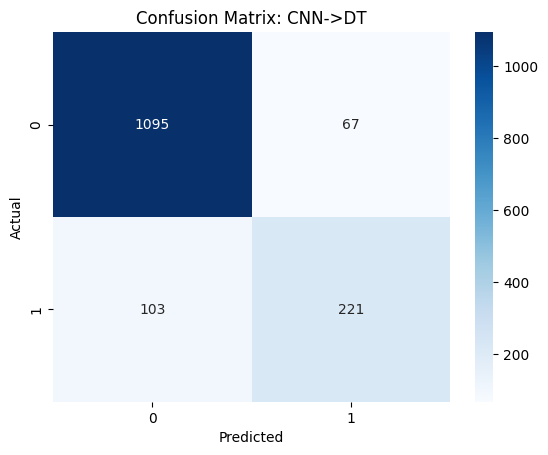

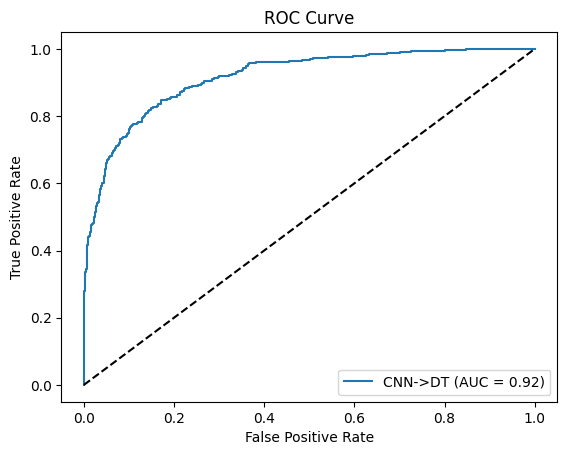

In [11]:
test_df_daily = df.loc[test_indices].groupby('Date').first().sort_index()

student_models = {
    'GRU->XGB': (gru_xgb, gru_test_probs),
    'GRU->DT':  (gru_dt, gru_test_probs),
    'CNN->XGB': (cnn_xgb, cnn_test_probs),
    'CNN->DT':  (cnn_dt, cnn_test_probs)
}

distillation_results = {}

for name, (model, teacher_probs) in student_models.items():
    
    raw_student_probs = model.predict(data['test']['beh'])
    
    y_true_daily, y_probs_daily = aggregate_daily(df, test_indices, data['test']['target'], raw_student_probs)    
    
    model_results = evaluation.evaluate_model(name, y_true_daily, y_probs_daily, test_df_daily)

    _, teacher_probs_daily = aggregate_daily(df, test_indices, data['test']['target'], teacher_probs)
    evaluation.calculate_fidelity(teacher_probs_daily, y_probs_daily)
    
    evaluation.plot_confusion_matrix(model_results['basic'], name)
    evaluation.plot_roc_curve(y_true_daily, y_probs_daily, name)
    
    distillation_results[name] = results

/tmp/ipython-input-343249518.py:17: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_raw, X_test_beh, max_display=10, show=False)


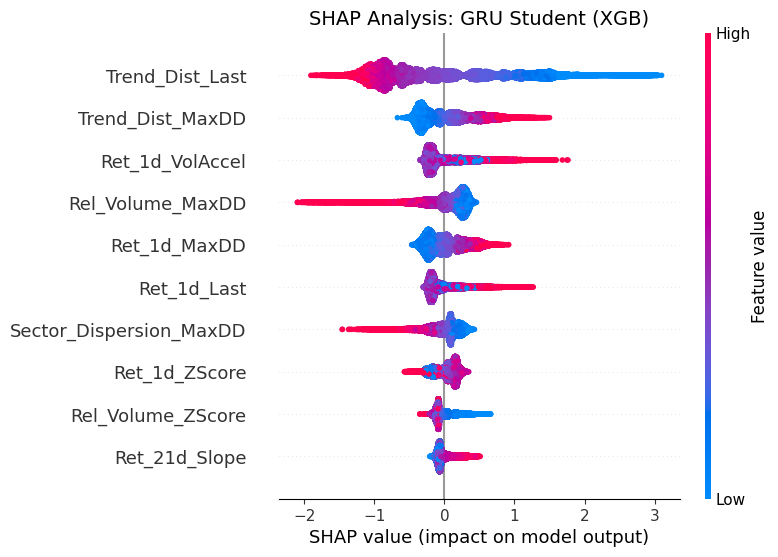

Peak Fragility for GRU Student (XGB) found on: 2020-04-02


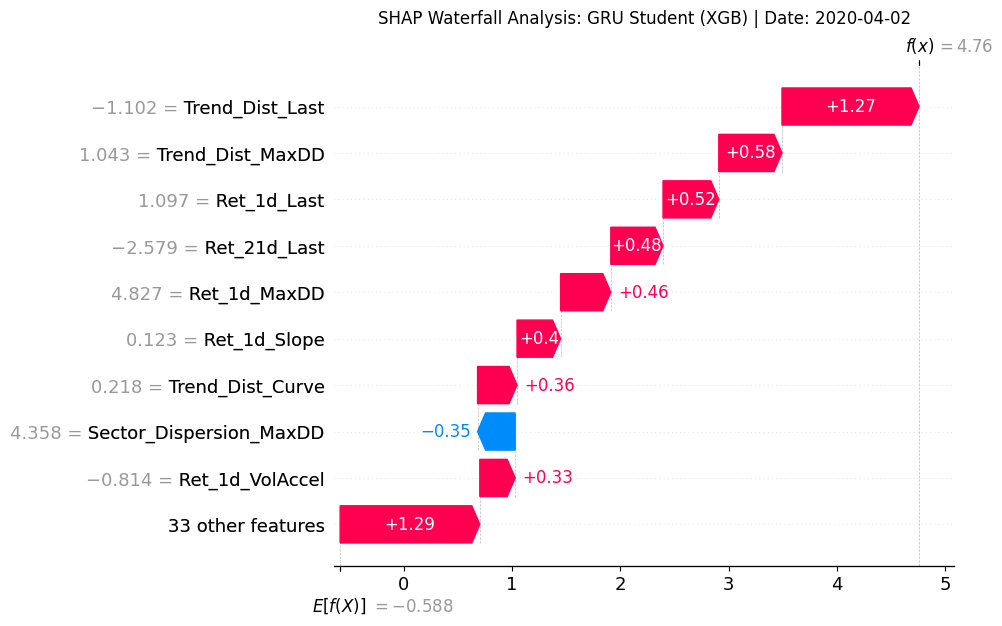

/tmp/ipython-input-343249518.py:17: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_raw, X_test_beh, max_display=10, show=False)


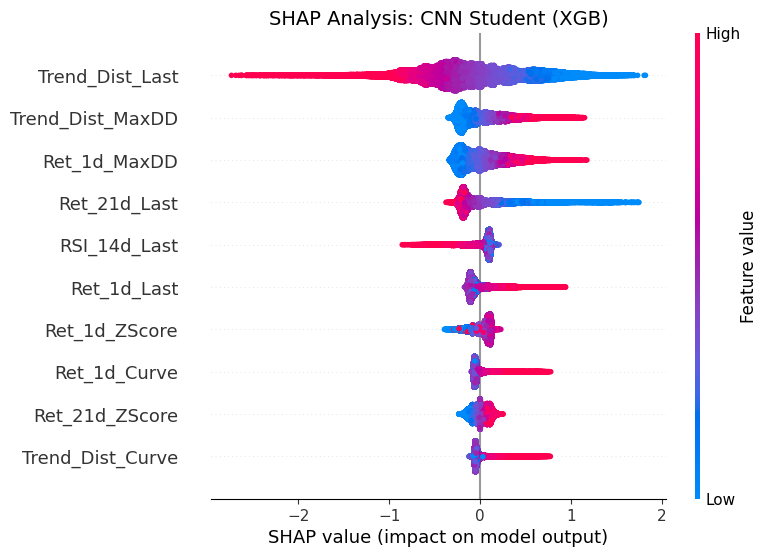

Peak Fragility for CNN Student (XGB) found on: 2020-03-23


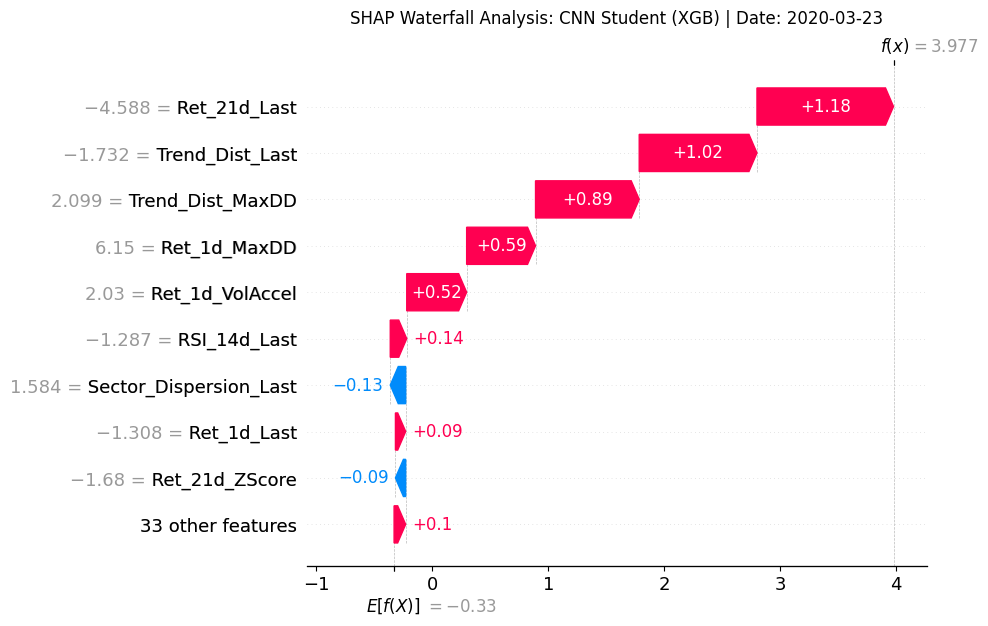

In [12]:
test_dates = pd.to_datetime(df.loc[data['test']['indices'], 'Date'])
covid_start, covid_end = '2020-02-01', '2020-05-01'

shap_models = {
    "GRU Student (XGB)": gru_xgb,
    "CNN Student (XGB)": cnn_xgb
}

feature_names = data['test']['feat_names']
X_test_beh = pd.DataFrame(data['test']['beh'], columns=feature_names)

for name, model in shap_models.items():
    
    explainer = shap.TreeExplainer(model)
    shap_values_raw = explainer(X_test_beh)
    
    shap.summary_plot(shap_values_raw, X_test_beh, max_display=10, show=False)
    plt.title(f"SHAP Analysis: {name}", fontsize=14)
    plt.show()

    df_shap = pd.DataFrame(shap_values_raw.values, columns=feature_names, index=test_dates)
    df_feat = pd.DataFrame(shap_values_raw.data, columns=feature_names, index=test_dates)
    
    daily_shap = df_shap.groupby(level=0).mean()
    daily_feat = df_feat.groupby(level=0).mean()
    
    daily_probs = explainer.expected_value + daily_shap.sum(axis=1)
    peak_date = daily_probs.loc[covid_start:covid_end].idxmax()
    
    print(f"Peak Fragility for {name} found on: {peak_date.date()}")

    daily_explanation = shap.Explanation(
        values=daily_shap.loc[peak_date].values,
        base_values=explainer.expected_value,
        data=daily_feat.loc[peak_date].values,
        feature_names=feature_names
    )

    shap.plots.waterfall(daily_explanation, max_display=10, show=False)
    plt.title(f"SHAP Waterfall Analysis: {name} | Date: {peak_date.date()}", pad=30)
    plt.show()

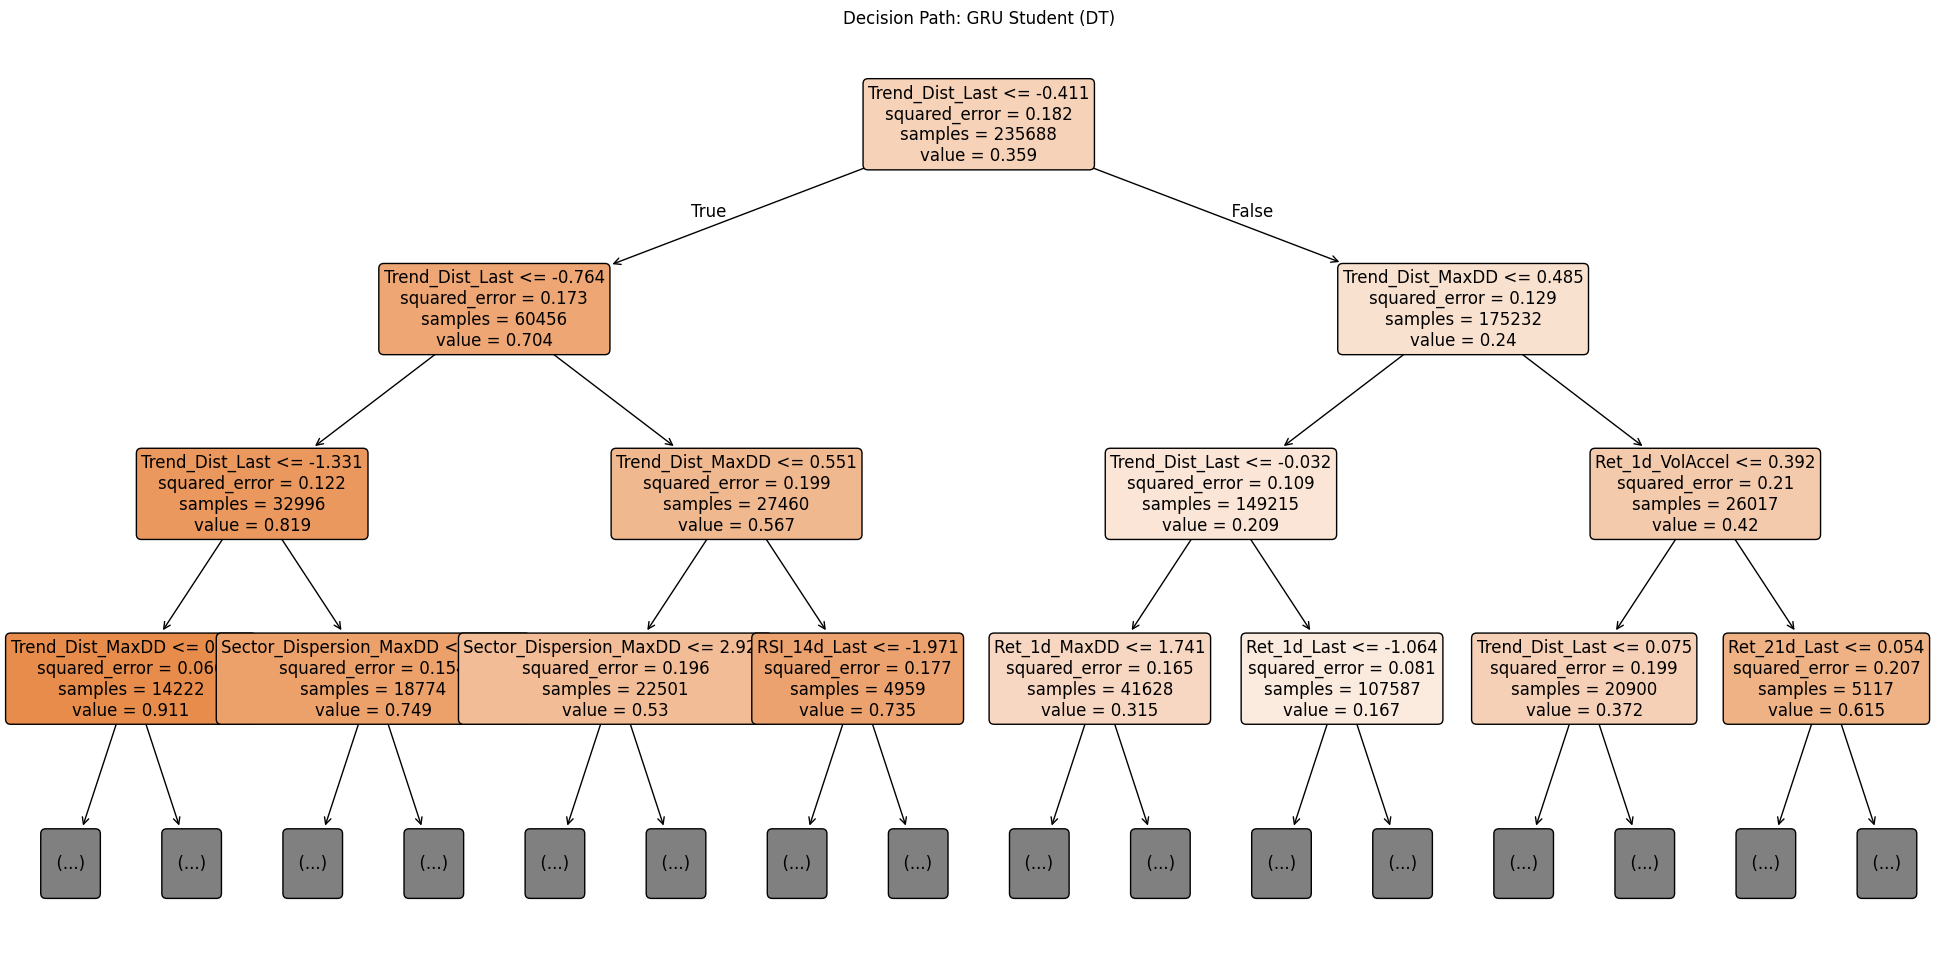

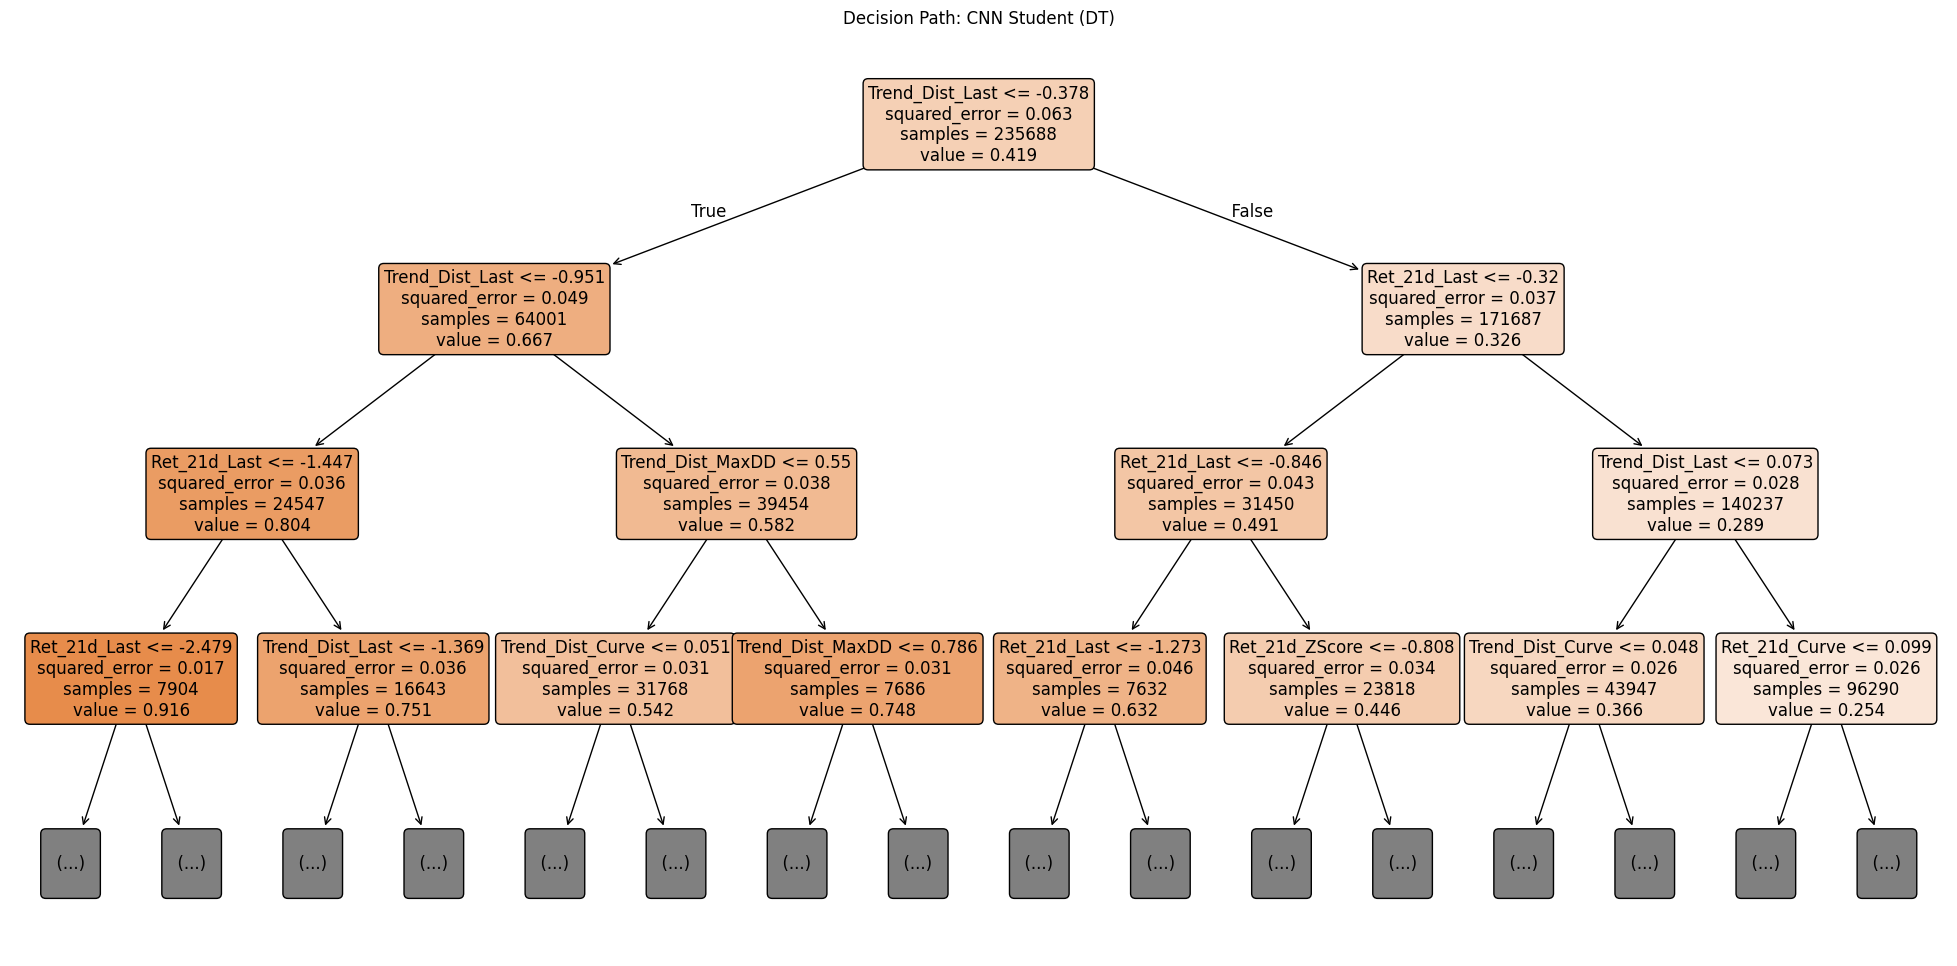

In [13]:
from sklearn.tree import plot_tree

tree_models = {
    "GRU Student (DT)": gru_dt,
    "CNN Student (DT)": cnn_dt
}

for name in tree_models:

    plt.figure(figsize=(25, 12))

    plot_tree(tree_models[name], 
            feature_names=feature_names, 
            max_depth=3,
            filled=True, 
            rounded=True, 
            fontsize=12)
    
    plt.title(f"Decision Path: {name}")
    plt.show()

In [14]:
regime_ts = df[['Date', 'Target_Regime_5d']].drop_duplicates('Date').sort_values('Date')

transition_dates = regime_ts[regime_ts['Target_Regime_5d'].diff() == 1]['Date']

print(transition_dates.tolist())

[Timestamp('2000-10-06 00:00:00'), Timestamp('2000-11-13 00:00:00'), Timestamp('2000-11-28 00:00:00'), Timestamp('2001-03-05 00:00:00'), Timestamp('2001-09-04 00:00:00'), Timestamp('2002-05-07 00:00:00'), Timestamp('2002-05-24 00:00:00'), Timestamp('2002-05-30 00:00:00'), Timestamp('2002-06-27 00:00:00'), Timestamp('2002-09-18 00:00:00'), Timestamp('2003-03-10 00:00:00'), Timestamp('2003-03-17 00:00:00'), Timestamp('2007-03-14 00:00:00'), Timestamp('2007-07-20 00:00:00'), Timestamp('2007-10-25 00:00:00'), Timestamp('2008-04-30 00:00:00'), Timestamp('2008-05-30 00:00:00'), Timestamp('2009-06-09 00:00:00'), Timestamp('2009-07-08 00:00:00'), Timestamp('2010-05-03 00:00:00'), Timestamp('2010-06-22 00:00:00'), Timestamp('2011-08-01 00:00:00'), Timestamp('2011-09-14 00:00:00'), Timestamp('2011-10-18 00:00:00'), Timestamp('2011-10-20 00:00:00'), Timestamp('2011-11-02 00:00:00'), Timestamp('2011-11-22 00:00:00'), Timestamp('2014-10-14 00:00:00'), Timestamp('2014-12-31 00:00:00'), Timestamp('20

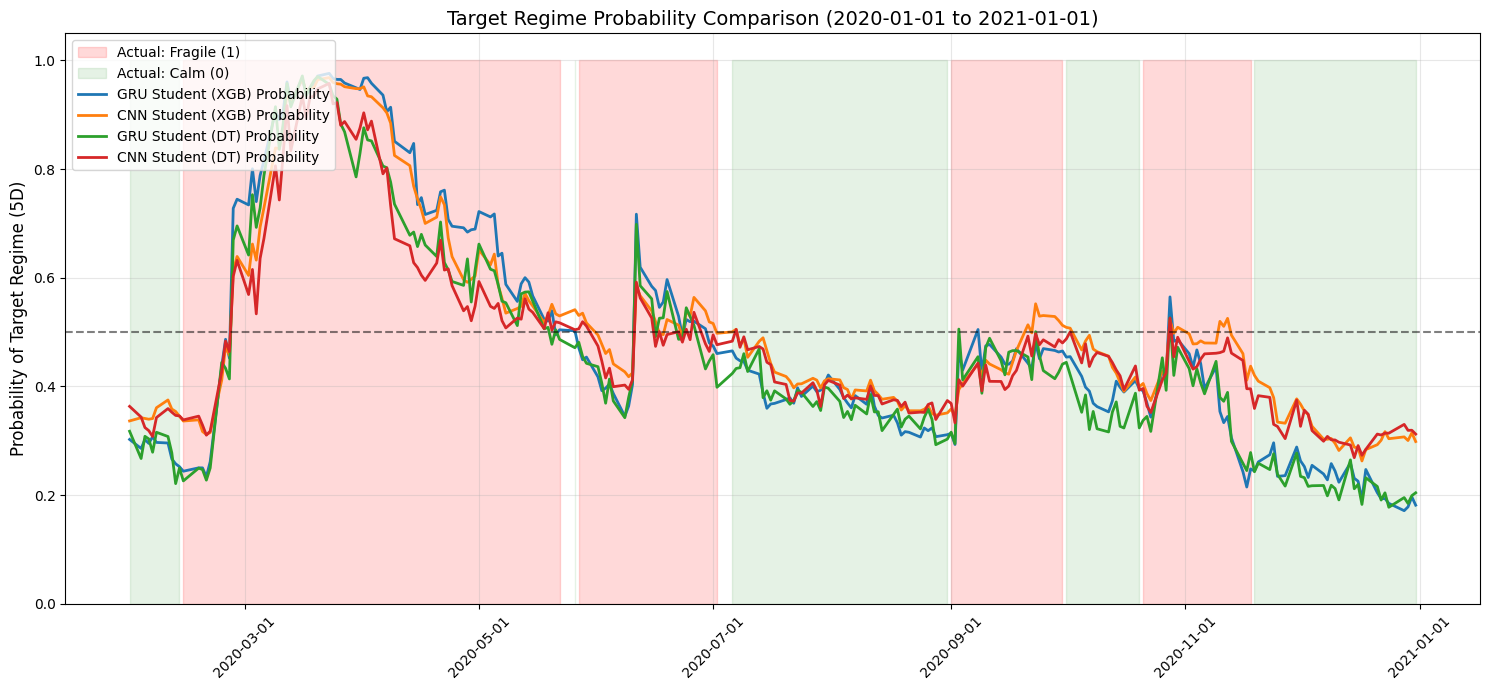

In [15]:
import src.evaluation as evaluation
import importlib
import pandas as pd
from src.data_utils import aggregate_daily

importlib.reload(evaluation)

comparison_probs = {}

student_models = {
    "GRU Student (XGB)": gru_xgb,
    "CNN Student (XGB)": cnn_xgb,
    "GRU Student (DT)": gru_dt,
    "CNN Student (DT)": cnn_dt
}

X_test_beh = data['test']['beh']
y_test_labels = data['test']['target']
test_df = df.loc[test_indices]

y_true_daily_ref = None
daily_index_ref = pd.Index(test_df['Date'].unique()).sort_values()

for name, model in student_models.items():
    probs = model.predict(X_test_beh)
    
    y_true_daily, y_probs_daily = aggregate_daily(df, test_indices, y_test_labels, probs)
    
    comparison_probs[name] = y_probs_daily
    y_true_daily_ref = y_true_daily

evaluation.plot_regime_comparison(
    comparison_probs, 
    y_true_daily_ref, 
    daily_index_ref, 
    start_date='2020-01-01', 
    end_date='2021-01-01'
)

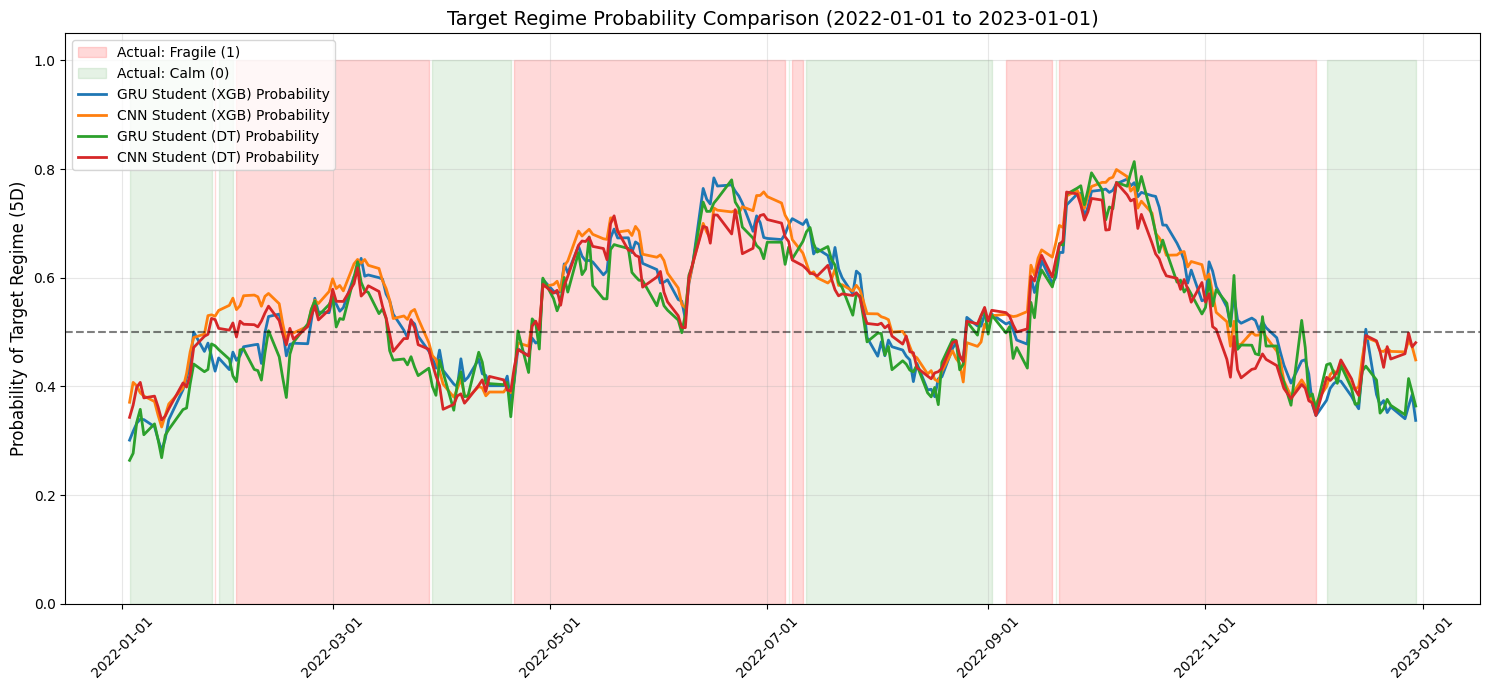

In [16]:
evaluation.plot_regime_comparison(
    comparison_probs, 
    y_true_daily_ref, 
    daily_index_ref, 
    start_date='2022-01-01', 
    end_date='2023-01-01'
)

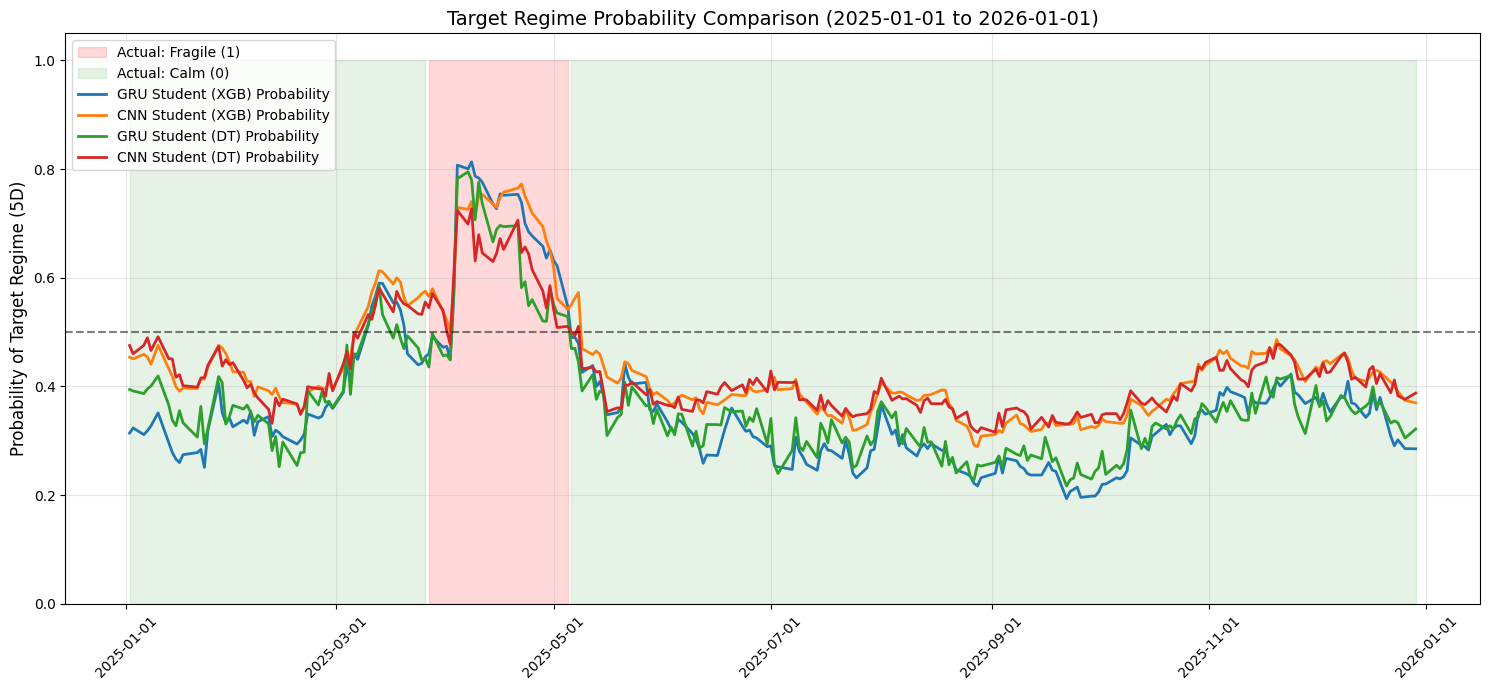

In [17]:
evaluation.plot_regime_comparison(
    comparison_probs, 
    y_true_daily_ref, 
    daily_index_ref, 
    start_date='2025-01-01', 
    end_date='2026-01-01'
)